# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter #подсчет значений - хорошо для классификации

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [46]:
Rm = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1]) # 2 класса - единицы и нолики

# Зададим функцию, которая будет возвращать энтропию по массиву ответов в вершине

def H_log(R):
    R_size = len(R) # Определяем количество объектов в вершине
    Classes = np.array(list(Counter(R).values())) # Определяем, сколько элементов каждого класса в вершине
    R = Classes/R_size # Переходим от количества элементов к долям каждого класса (относительной частоте появления каждого класса)
    return -np.sum(R*np.log(R)) # По относительным частотам считаем энтропию

ent = round(H_log(Rm), 2)
print(f'Энтропия распределения классов равна {ent}')

# Важное замечание: в эту функцию подается массив ответов, а не относительные частоты появления классов. Если какого-то класса нет, то он вообще не попадет в относительные частоты (в массиве относительных частот не будет нулей)
# Мы можем пренебречь этими нулями, так как без них энтропия будет такая же

Энтропия распределения классов равна 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [47]:
# Разибение, где в левое поддерево попадают все объекты первого класса, а в правое - второго класса
Rl = np.array([0, 0, 0, 0, 0, 0, 0, 0])
Rr = np.array([1, 1])

# Зададим функцию, которая будет возвращать индекс Джини по массиву ответов в вершине

def Gini(R):
    R_size = len(R) # Определяем количество объектов в вершине
    Classes = np.array(list(Counter(R).values())) # Определяем, сколько элементов каждого класса в вершине
    R = Classes/R_size # Переходим от количества элементов к долям каждого класса (относительной частоте появления каждого класса)
    return np.sum(R*(1-R)) # По относительной частоте считаем индекс Джини

# Теперь зададим функцию, которая будет считать критерий информативности разбиения

def Q(Rl, Rr, Rm, entropy: str):
    if entropy == 'log':
        return H_log(Rm) - len(Rl)/len(Rm)*H_log(Rl) - len(Rr)/len(Rm)*H_log(Rr)
    elif entropy == 'gini':
        return Gini(Rm) - len(Rl)/len(Rm)*Gini(Rl) - len(Rr)/len(Rm)*Gini(Rr)
    elif entropy == 'var':
        return np.var(Rm) - len(Rl)/len(Rm)*np.var(Rl) - len(Rr)/len(Rm)*np.var(Rr) # Из-за 2го задания сразу добавляе дисперсию
    else:
        return 'Entropy for Q should be log, gini or var'

Q_ = round(Q(Rl, Rr, Rm, 'gini'), 2)
print(f'Критерий информативности при таком распределении равен {Q_}')

Критерий информативности при таком распределении равен 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [48]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
pred = np.mean(leaf) # Предсказание - просто среднее значение всех объектов в вершине
print(f'Предсказания модели равны {pred}')

Предсказания модели равны 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [49]:
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [50]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], # то есть в функцию идет только 1 признак и мы ищем порог для него
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real",
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.array(feature_vector) # Если нам дали части ДатаФреймов, то на этом шаге они станут массивами Numpy (?)
    target_vector = np.array(target_vector)
    
    # Функции, которые разделяют вершину на 2 по порогу
    def spliter_real(feature_vector: np.ndarray, target_vector: np.ndarray, t: float): # Для вещественных признаков
        Rl, Rr = [], [] # 2 дочерние вершины
        Rl = target_vector[feature_vector <= t] # В левую вершину добавляем ответы, у которых признак меньше или равен t
        Rr = target_vector[feature_vector > t] # В правую вершину добавляем ответы, у которых признак больше t
        return [Rl, Rr]
    
    def spliter_categorial(feature_vector: np.ndarray, target_vector: np.ndarray, t: float): # Для категориальных переменных
        Rl, Rr = [], [] # 2 дочерние вершины
        Rl = target_vector[feature_vector == t] # В левую вершину добавляем ответы, у которых признак равен t
        Rr = target_vector[feature_vector != t] # В правую вершину добавляем ответы, у которых признак не равен t
        return [Rl, Rr]
    
    #for real
    if feature_type == 'real':
        features_sorted = np.unique(np.sort(feature_vector)) # Берем уникальные отсротированные значения, чтобы перебрать все пороги
        inf_list = [] # Список с критериями информативности
        t_list = [] # Список с порогами
        for i in range (1, len(features_sorted)):
            t = np.mean([features_sorted[i-1], features_sorted[i]]) # Берем среднее из двух элементов в качестве порога
            Rl, Rr = spliter_real(feature_vector, target_vector, t) # Делим вершину на 2 дочерние порогом
            if task == 'classification':
                inf = Q(Rl, Rr, feature_vector, 'gini') # Критерий информативности для классификации
            elif task == 'regression':
                inf = Q(Rl, Rr, feature_vector, 'var') # Критерий информативности для регрессии
            else:
                return 'Error: task should be classification or regression'
            inf_list.append(inf) # Добавляем в список критерий информативности и порог
            t_list.append(t)

    #for categorial
    elif feature_type == 'categorical':
        inf_list = []
        t_list = np.unique(feature_vector) # Критерий разбиения - все уникальные категории
        for t in t_list:
            Rl, Rr = spliter_categorial(feature_vector, target_vector, t)# Дальше аналогично
            if task == 'classification':
                inf = Q(Rl, Rr, feature_vector, 'gini') # Критерий информативности для классификации
            elif task == 'regression':
                inf = Q(Rl, Rr, feature_vector, 'var') # Критерий информативности для регрессии
            else:
                return 'Error: taks should be classification or regression'
            inf_list.append(inf)
    
    else:
        return 'Error: feature_type should be real or categorical'
    
    best_index = inf_list.index(max(inf_list)) # Если максимумов несколько, то он просто возьмет ближайший и сплит как раз будет минимальным
    inf_best = inf_list[best_index] 
    t_best = t_list[best_index]
    return (t_list, inf_list, t_best, inf_best)

    pass

Эту функцию можно протестировать на датасете `California`.

In [51]:
from sklearn.datasets import fetch_california_housing

In [52]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

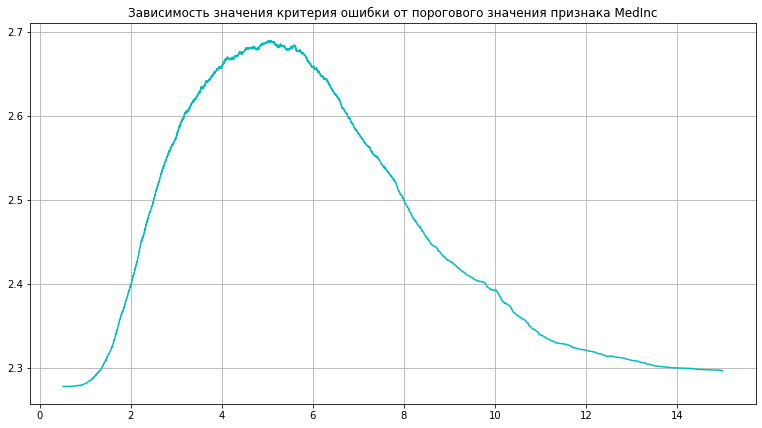

In [54]:
t_todraw, inf_todraw = find_best_split(X['MedInc'], y, 'regression', 'real')[0], find_best_split(X['MedInc'], y, 'regression', 'real')[1]

plt.figure(figsize=(13, 7))
plt.title('Зависимость значения критерия ошибки от порогового значения признака MedInc')
plt.plot(t_todraw, inf_todraw, 'c')
plt.grid()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [10]:
inf_ = 0

for column in X.columns:
    inf_best = find_best_split(X[column], y, 'regression', 'real')[3]
    if inf_best > inf_:
        inf_ = inf_best
        t_best = find_best_split(X[column], y, 'regression', 'real')[2]
        feature_best = column
print(f'Best predicate: feature is {feature_best}, threshold is {t_best}')

Best predicate: feature is Population, threshold is 1160.5


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [11]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        # Бонуса не будет...

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold # Добавила
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold # Добавила
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class'] # Для листовой вершины просто выдаем класс
        
        if self._feature_types[node["feature_split"]] == 'categorical': # Если признак, по которому нужно разбивать вершину, категориальный, то проверяем соответствие этого признака категории и относим к одной из двух дочерних вершин
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        
        if self._feature_types[node["feature_split"]] == 'real': # Если значимый признак вещественный, то проверяем признак по порогу (больше или меньше) и относим к одной из двух дочерних вершин
            if x[node['feature_split']] <= node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [12]:
data = pd.read_csv('students.csv')
X = data.drop('UNS', axis = 1) # Удаляем столбец с ответами
X = X.drop(X.columns[0], axis = 1) # Неинформативный признак, тоже удаляем
y = data['UNS'] # Отдельный столбец с ответами
X

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


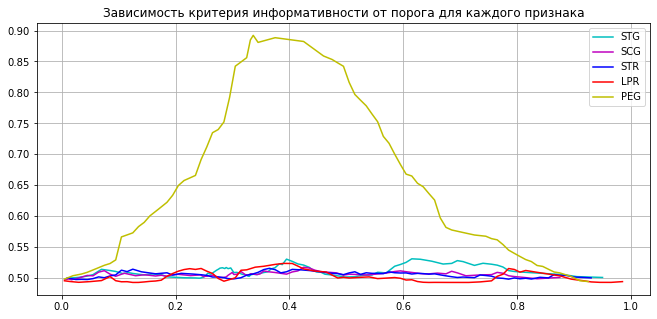

In [13]:
plt.figure(figsize=(11, 5))

plt.title('Зависимость критерия информативности от порога для каждого признака')
plt.plot(find_best_split(X['STG'], y, 'classification', 'real')[0], find_best_split(X['STG'], y, 'classification', 'real')[1], 'c', label = 'STG')
plt.plot(find_best_split(X['SCG'], y, 'classification', 'real')[0], find_best_split(X['SCG'], y, 'classification', 'real')[1], 'm', label = 'SCG')
plt.plot(find_best_split(X['STR'], y, 'classification', 'real')[0], find_best_split(X['STR'], y, 'classification', 'real')[1], 'b', label = 'STR')
plt.plot(find_best_split(X['LPR'], y, 'classification', 'real')[0], find_best_split(X['LPR'], y, 'classification', 'real')[1], 'r', label = 'LPR')
plt.plot(find_best_split(X['PEG'], y, 'classification', 'real')[0], find_best_split(X['PEG'], y, 'classification', 'real')[1], 'y', label = 'PEG')

plt.legend()
plt.grid()
plt.show()

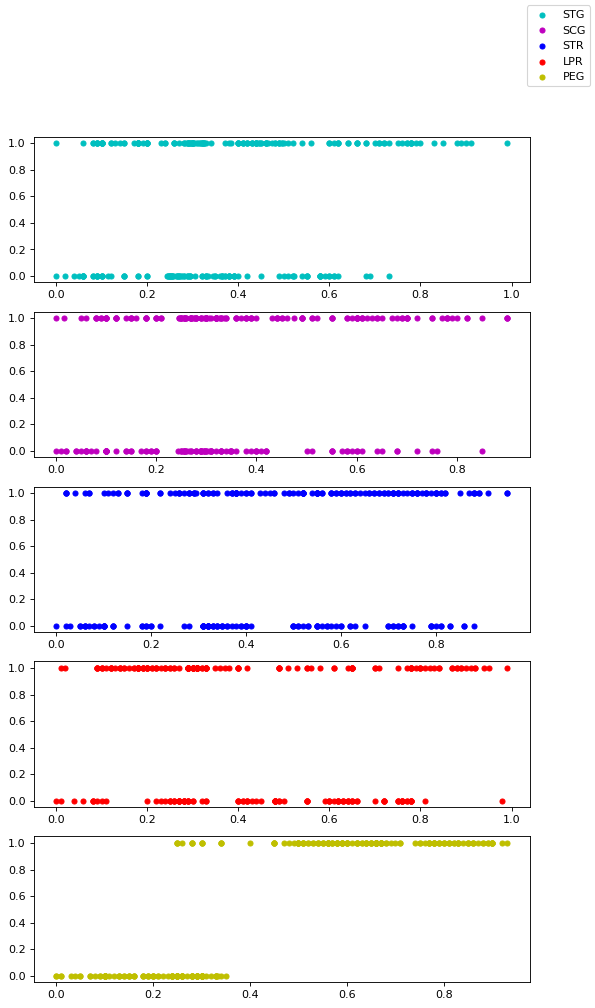

In [14]:
# Диаграммы рассеяния

fig, axs = plt.subplots(5, 1, figsize=(8, 14), dpi=80)

axs[0].scatter(X['STG'], y, s = 20, color = 'c', label = 'STG')
axs[1].scatter(X['SCG'], y, s = 20, color = 'm', label = 'SCG')
axs[2].scatter(X['STR'], y, s = 20, color = 'b', label = 'STR')
axs[3].scatter(X['LPR'], y, s = 20, color = 'r', label = 'LPR')
axs[4].scatter(X['PEG'], y, s = 20, color = 'y', label = 'PEG')

fig.legend()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значений критериев информативности, деление выборки нужно производить по признаку PEG. Результат согласуется с визуальной оценкой, два класса можно поделить именно по этому признаку.

Для "хороших" признаков кривая напоминает колокол с максимумов в лучшем пороге, а для "плохих" признаков эта кривая будет колебатся около одних и тех же низких значений.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [15]:
from sklearn import preprocessing

In [16]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
le = preprocessing.LabelEncoder()
for column in mushrooms.columns.to_list():
    le.fit(mushrooms[column])
    mushrooms[column] = le.transform(mushrooms[column])

X = mushrooms.drop(mushrooms.columns[0], axis = 1)
y = mushrooms[mushrooms.columns[0]]
X

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
1,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
2,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
3,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
4,5,3,9,1,0,1,0,0,5,0,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8119,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8120,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8121,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 15)

feature_types = ['categorical'] * X_train.shape[1]
DT = DecisionTree(feature_types)
DT.fit(X_train.to_numpy(), np.array(y_train))

print(DT.predict(X_test.to_numpy())) # predictions
print(f'Accuracy is {np.mean(DT.predict(X_test.to_numpy()) == y_test)}') # accuracy вручную

[0 0 1 ... 0 0 0]
Accuracy is 0.9985228951255539


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [20]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [21]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

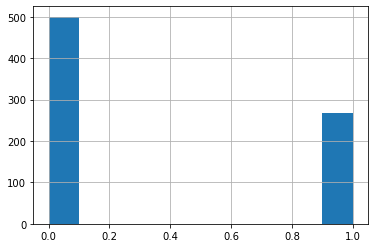

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
X = data.drop(columns = ['Outcome'], axis = 1)
Y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 43)

In [24]:
# Проверим соотношение размеров выборок
check = np.array([X_train_train.shape[0], X_valid.shape[0], X_test.shape[0]])
check = check / sum(check)
check

array([0.48828125, 0.2109375 , 0.30078125])

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [25]:
from sklearn.metrics import f1_score

In [26]:
f1_list = [] # список для значений f1
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 100] # значения для перебора
min_sample_leaf = [1, 3, 5, 10, 15, 20, 30, 50, 75, 100]

for i in max_depth:
    for j in min_sample_leaf:
        dt = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j, random_state=20) # Задаем гиперпараметры
        dt.fit(X_train_train, y_train_train) # Обучаем дерево
        f1 = f1_score(y_valid, dt.predict(X_valid)) # Проверяем качество
        print(f'F1 score for max depth = {i} and min_sample_leaf = {j}: {f1}')
        f1_list.append((f1, i, j)) # Добавляем значения f1 и гиперпараметров одним кортежем в список

F1 score for max depth = 1 and min_sample_leaf = 1: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 3: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 5: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 10: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 15: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 20: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 30: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 50: 0.4146341463414634
F1 score for max depth = 1 and min_sample_leaf = 75: 0.5217391304347826
F1 score for max depth = 1 and min_sample_leaf = 100: 0.6271186440677966
F1 score for max depth = 2 and min_sample_leaf = 1: 0.4146341463414634
F1 score for max depth = 2 and min_sample_leaf = 3: 0.4146341463414634
F1 score for max depth = 2 and min_sample_leaf = 5: 0.4146341463414634
F1 score for max depth = 2 and min_sample_leaf = 10: 0.41463414634146

F1 score for max depth = 100 and min_sample_leaf = 30: 0.5252525252525253
F1 score for max depth = 100 and min_sample_leaf = 50: 0.5511811023622047
F1 score for max depth = 100 and min_sample_leaf = 75: 0.5217391304347826
F1 score for max depth = 100 and min_sample_leaf = 100: 0.6271186440677966


In [27]:
# В явном виде найдем лучший набор гиперпараметров

best = sorted(f1_list, reverse = True)[0] # сортируем по f1 в порядке убывания и берем первый набор, в котором f1 максимальна
best_f1 = best[0]
best_max_depth = best[1]
best_min_sample_leaf = best[2]

dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_sample_leaf, random_state=20)
dt.fit(X_train, y_train)

print(f'Accuracy on test sample is {accuracy_score(y_test, dt.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, dt.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, dt.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, dt.predict(X_test))}')
print(f'Best f1 on train sample: {best_f1}, best max_depth: {best_max_depth}, best min_sample_leaf: {best_min_sample_leaf}')

Accuracy on test sample is 0.7272727272727273
Precision on test sample is 0.580952380952381
Recall on test sample is 0.7625
ROC-AUC on test sample is 0.7355546357615894
Best f1 on train sample: 0.6666666666666666, best max_depth: 4, best min_sample_leaf: 5


Не очень высокий precision - модель много объектов относит к ложноположительному классу.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [28]:
bc = BaggingClassifier(n_estimators=50)
bc.fit(X_train, y_train)

print(f'Accuracy on test sample is {accuracy_score(y_test, bc.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, bc.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, bc.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, bc.predict(X_test))}')

Accuracy on test sample is 0.7359307359307359
Precision on test sample is 0.6144578313253012
Recall on test sample is 0.6375
ROC-AUC on test sample is 0.7127897350993377


Accuracy и precision почти всегда выше у бэггинга, recall всегда ниже. В целом бэггинг оказывается немножко лучше.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [40]:
max_depth = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
min_samples_split = [2, 3, 5, 10, 15, 20, 30, 50]

f1_mean_list = []
for i in max_depth:
    for j in min_samples_split:
        rfc = RandomForestClassifier(n_estimators=50, max_depth=i, min_samples_split=j)
        kf = KFold(n_splits=5)
        f1_mean = np.mean(cross_val_score(rfc, X_train, y_train, cv = kf, scoring = 'f1'))
        print(f'Mean F1 score for max depth = {i} and min_samples_split = {j}: {f1_mean}')
        f1_mean_list.append((f1_mean, i, j))

Mean F1 score for max depth = 1 and min_samples_split = 2: 0.31218708827404484
Mean F1 score for max depth = 1 and min_samples_split = 3: 0.32405904870164637
Mean F1 score for max depth = 1 and min_samples_split = 5: 0.25087640922662696
Mean F1 score for max depth = 1 and min_samples_split = 10: 0.3242894056847545
Mean F1 score for max depth = 1 and min_samples_split = 15: 0.26776513277255487
Mean F1 score for max depth = 1 and min_samples_split = 20: 0.28952789501805326
Mean F1 score for max depth = 1 and min_samples_split = 30: 0.26193447143695103
Mean F1 score for max depth = 1 and min_samples_split = 50: 0.3180676328502416
Mean F1 score for max depth = 2 and min_samples_split = 2: 0.5285092864125123
Mean F1 score for max depth = 2 and min_samples_split = 3: 0.5072581358819496
Mean F1 score for max depth = 2 and min_samples_split = 5: 0.49432670044905863
Mean F1 score for max depth = 2 and min_samples_split = 10: 0.5455745123121203
Mean F1 score for max depth = 2 and min_samples_spl

In [41]:
new_best = sorted(f1_mean_list, reverse = True)[0]
best_mean_f1 = new_best[0]
best_max_depth_rf = new_best[1]
best_min_samples_split = new_best[2]

rfc = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split)
rfc.fit(X_train, y_train)

print(f'Accuracy on test sample is {accuracy_score(y_test, rfc.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, rfc.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, rfc.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, rfc.predict(X_test))}')
print(f'Best f1 on train sample: {best_mean_f1}, best max_depth: {best_max_depth_rf}, best min_sample_split: {best_min_samples_split}')

Accuracy on test sample is 0.7359307359307359
Precision on test sample is 0.6144578313253012
Recall on test sample is 0.6375
ROC-AUC on test sample is 0.7127897350993377
Best f1 on train sample: 0.6526216967772285, best max_depth: 10, best min_sample_split: 3


In [42]:
# Еще раз результаты для трех моделей
print('FOR ONE TREE')
print(f'Accuracy on test sample is {accuracy_score(y_test, dt.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, dt.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, dt.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, dt.predict(X_test))}')
print('\n')
print('FOR BAGGING')
print(f'Accuracy on test sample is {accuracy_score(y_test, bc.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, bc.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, bc.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, bc.predict(X_test))}')
print('\n')
print('FOR RANDOM FOREST')
print(f'Accuracy on test sample is {accuracy_score(y_test, rfc.predict(X_test))}')
print(f'Precision on test sample is {precision_score(y_test, rfc.predict(X_test))}')
print(f'Recall on test sample is {recall_score(y_test, rfc.predict(X_test))}')
print(f'ROC-AUC on test sample is {roc_auc_score(y_test, rfc.predict(X_test))}')

FOR ONE TREE
Accuracy on test sample is 0.7272727272727273
Precision on test sample is 0.580952380952381
Recall on test sample is 0.7625
ROC-AUC on test sample is 0.7355546357615894


FOR BAGGING
Accuracy on test sample is 0.7359307359307359
Precision on test sample is 0.6144578313253012
Recall on test sample is 0.6375
ROC-AUC on test sample is 0.7127897350993377


FOR RANDOM FOREST
Accuracy on test sample is 0.7359307359307359
Precision on test sample is 0.6144578313253012
Recall on test sample is 0.6375
ROC-AUC on test sample is 0.7127897350993377


Мы видим, что результаты несильно отличаются, однозначно сказать, что какая-то модель сильно лучше, по этим метрикам нельзя.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

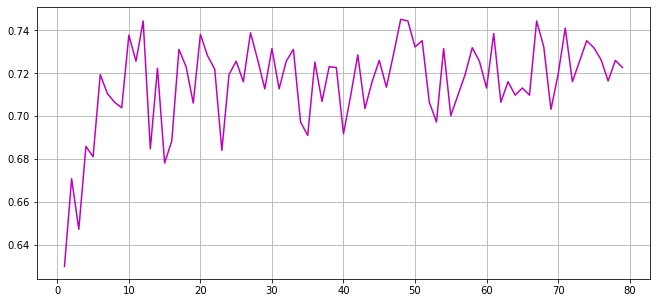

In [43]:
x_coord = []
y_coord = []

for i in range (1, 80):
    rfc_ = RandomForestClassifier(n_estimators=i, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split)
    rfc_.fit(X_train, y_train)
    x_coord.append(i)
    y_coord.append(roc_auc_score(y_test, rfc_.predict(X_test)))

plt.figure(figsize=(11, 5))
plt.plot(x_coord, y_coord, 'm')
plt.grid()
plt.show()

Результаты в рандомном лесе колеблются около одного и того же значения, то есть лес не переобучается из-за увеличения количества деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

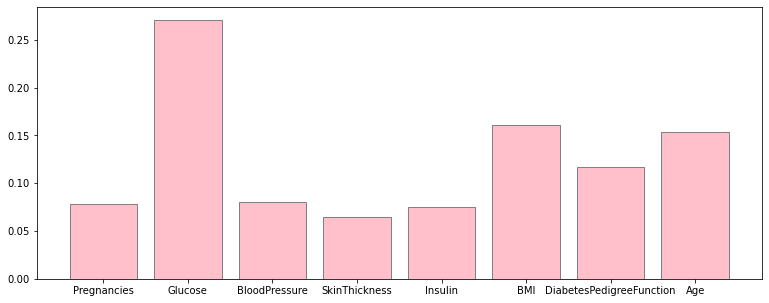

In [44]:
plt.figure(figsize=(13, 5))
plt.bar(X_train.columns, rfc_.feature_importances_, color = 'pink', edgecolor = 'grey')
plt.show()

Самым важным признаком оказалась концетрация глюкозы.